# Introduction
## Objectives
1. The primary objective of this program is to determine whether the mixed audio can be accurately recreated using the mixing coefficients provided in the song collection of the BandHub dataset. If this is the case, the mixed audio need not be stored and can be recreated as and when required, thereby saving us significant space on the file server.

2. In a handful of cases, the same mix has two mixing coefficients. One in the settings dictionary, and the other in the audioChannels list, which is within the settings dictionary. Most times these are just approximation errors. However, in some cases the differences are significant. Therefore, the secondary objective is to clarify which of these multiple mixing coefficients is more accurate.

## Code Organization
1. Imports
2. Connect to mongoDB client
3. Get all collections: Songs, Videos, Tracks, and Posts
4. Function definitions
 * All functions have been elaborated on in the markdown cells above them.
5. Main script
 * This script calls all the functions as and when required to accomplish both objectives.

### 1. Imports

In [1]:
import pymongo
import pandas as pd
#from pandas import Series
import numpy as np
np.set_printoptions(threshold='nan')
from numpy.linalg import inv
from scipy import signal
from scipy.io import wavfile
import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline
#from collections import Counter
from bson.objectid import ObjectId
import json
import pprint
from pydub import AudioSegment
import urllib
import fnmatch
import os
import requests
import ffmpy
import subprocess
import librosa
import librosa.display
import time

### 2. Connect to mongoDB client

In [2]:
client = pymongo.MongoClient('localhost',27017)
#client = pymongo.MongoClient('localhost',32768)
db = client.get_database('b=bandhub')

### 3. Get all collections: Songs, Videos, Tracks, and Posts

In [3]:
songCol = db.get_collection('songsStream')
vidCol = db.get_collection('mergedVideos')
trackCol = db.get_collection('tracksStream')
postCol = db.get_collection('posts')
[songCol.count(), vidCol.count(), trackCol.count(), postCol.count()]

[425706, 198169, 915582, 494867]

### 4. Function definitions

From this dataset, we are only concerned with tracks that have "public" access. This is denoted by the variable "songAccess", which and is set to 1 for public tracks.<br>
Conversely, many mixes have a lot of unused public tracks. The tracks that actually make the final mix are titled "published" tracks. Information about the published tracks in a mix are available only in the post collection, and so this function queries the post collection to return the relevant documents.<br>
To summarize, this generator returns the documents in the post collection that have a user-specified number (num_track) of published tracks. For our evaluation purposes, we have restricted num_track to be greater than 2.

In [4]:
def get_published_tracks(num_track):
    """ This generator function returns all post documents with "num_track" published tracks, where num_track > 2.
    ----------
    Arguments:
        num_track: Number of public, published tracks per mix

    Returns:
        docs: All documents from the post collection that satisfy the aforementioned condition
    """
    
    pub_tracks = postCol.find({'songAccess':{'$exists': True}}, {'participantsInfo':1 ,'songAccess':1, 'objectId':1})
    for docs in pub_tracks:
        if(docs['songAccess'] == 1):
            if(len(docs['participantsInfo']['publishedTracks']) == num_track):
                yield docs

This function aids in achieving the objective of identifying the mixes that contain multiple mixing coefficients, to identify which of those coefficients are better to recreate the mix. First, it sifts through all the documents returned from the get_published_tracks function. Then, it checks and keeps a track of any mixes that have missing published track information. If all the information is present, it then checks for mixes that have multiple volume fields. If such mixes are found, it rounds the track volumes associated with each of its constituent published tracks up to 2 decimal places to circumvent the approximation problem (e.g., volumes 0.987221 and 0.99 should not be considered different). The two volumes of each of these tracks are then compared, and if they are different, the post ID and the song ID of the mix are appended to a list and returned.

In [5]:
def get_processed_audio_ids(num_track):
    """ This function computes a list of the post IDs & master song IDs of those mixes generated by the
    get_published_tracks function that contain multiple mixing coefficients associated with the same mix.
    ----------
    Arguments:
        num_track: Number of public, published tracks per mix

    Returns:
        pub_songs: A list of tuples containing relevant post & track IDs
    """
    
    pub_docs = [x for x in get_published_tracks(num_track)]
    count_mixes = len(pub_docs)
    print("Number of mixes with " + str(num_track) + " published tracks: " + str(count_mixes))
    missing_song_id = []
    missing_pubtrack = []
    index_required = []
    pub_songs = []
    for j in range(count_mixes):
        pub_tracks = []
        post_id = pub_docs[j]['_id']
        song_id = pub_docs[j]['objectId']
        
        song_look_up = songCol.find({'masterSongId' : song_id})
        
        for i in range(num_track):
            pub_tracks.append(pub_docs[j]['participantsInfo']['publishedTracks'][i]['_id'])
                                
        if song_look_up is -1:
            missing_song_id.append(song_id)
            pprint.pprint('Error: SongID not found in Song Collection!')
        else:
            for song_docs in song_look_up:
                for i in range(len(pub_tracks)):
                    if(str(pub_tracks[i]) not in song_docs['settings']):
                        missing_pubtrack.append(pub_tracks[i])   
                        break
                    else:
                        if ('volume' in song_docs['settings'][str(pub_tracks[i])]['audioChannels'][0] and 'volume' in song_docs['settings'][str(pub_tracks[i])]):
                            if (round(song_docs['settings'][str(pub_tracks[i])]['audioChannels'][0]['volume'],2) != round(song_docs['settings'][str(pub_tracks[i])]['volume'],2)):
                                index_required.append(j)
                                pub_songs.append((post_id,song_id))
                                break
                            else:
                                continue
                        else:
                            #print('Mixing coefficient missing')
                            break

    return pub_songs

The file URLs in the dataset are of the following format:<br>
http://bandhubwebmedia1.blob.core.windows.net/files/520c0d243262aac9f04d4351-520c0d8753294aac9f04d4353.ogg<br>
We can see that the filename is present in this string after the last separator (/). This function strips the file name from the given file URL and returns it.

In [6]:
def get_filename(file):
    """ This function strips the filename along with the file extension from the file URL.
    ----------
    Arguments:
        file: file URL

    Returns:
        filepath: file path
    """
    
    filePath = file.split('/')
    return filePath[- 1]

The mixing coefficients necessary to recreate a mix are the following:
* pub_t_vol: Track volume in the settings dictionary
* pub_t_vol_ch: Track volume in the audioChannels list, nestled inside the settings dictionary
* ogg_paths: File paths of the tracks on the server.
* start_times: Track start times<br>
Given a song ID and post ID unique to a mix, this function queries the corresponding collections and extracts the above information for every published track in the mix.<br>
The track volumes are all rounded to 2 decimal places. The file URL is fetched from the effectsAudioURL field, which provides processed tracks (i.e., tracks with effects and processing). If not found, it is fetched from the fileURL field, which provides the raw track file.<br>
The start times for each track are queried from the track collection.

In [7]:
def get_mixing_coeff(num_track, song_id, post_id):
    """ This function gathers all mixing coefficients necessary to remix a song using its constituent
    published tracks.
    ----------
    Arguments:
        num_track: Number of public, published tracks per mix
        song_id: Song ID
        post_id: Post ID

    Returns:
        pub_t_vol: Published track volumes from the settings field in the song collection
        pub_t_vol_ch: Published track volumes from the audioChannels field within settings in the song collection
        ogg_paths: Processed (if available) or unprocessed file URLs of each published track
        start_times: Start times of each published track
    """
    
    pub_t_vol = []
    pub_t_vol_ch = []
    ogg_paths = []
    start_times = []
    track_filenames = []
    pub_tracks = []

    song_doc = songCol.find({'masterSongId' : song_id})
    post_doc = postCol.find({'_id' : post_id})
    
    for docs in post_doc:
        for i in range(num_track):
            pub_tracks.append(docs['participantsInfo']['publishedTracks'][i]['_id'])
    
    for docs in song_doc:    
        for i in range(len(pub_tracks)):
            if(str(pub_tracks[i]) in docs['settings']):
                pub_t_vol.append(round(docs['settings'][str(pub_tracks[i])]['volume'],2))
                if ('volume' in docs['settings'][str(pub_tracks[i])]['audioChannels'][0]):
                    pub_t_vol_ch.append(round(docs['settings'][str(pub_tracks[i])]['audioChannels'][0]['volume'],2))
                else:
                    pub_t_vol_ch.append(round(docs['settings'][str(pub_tracks[i])]['volume'],2))
            
                gettrack = trackCol.find({'_id' : pub_tracks[i]})
                for tdocs in gettrack:
                    start_times.append(tdocs['startTimeValue'])
                    if('effectsAudioUrl' in docs['settings'][str(pub_tracks[i])]):
                        ogg_paths.append(docs['settings'][str(pub_tracks[i])]['effectsAudioUrl'])
                    else:
                        ogg_paths.append(tdocs['audioChannels'][0]['fileUrl'])
            else:
                print('Missing published track!')
        
    return pub_t_vol, pub_t_vol_ch, ogg_paths, start_times

This function changes the default working directory to a user-specified folder in the user's scratch directory.

In [8]:
def set_path():
    """ This function sets the default download path to a subfolder within the user's scratch folder.
    """

    path = '/scratch/rrs432/tracks'
    os.chdir(path)

Given the file's path on the server, this function downloads the file (as is) onto the local working directory. 

In [9]:
def download_track(ogg_path):
    """ This function downloads the track using its filepath to the default download folder.
    ----------
    Arguments:
        ogg_path: file path
    """    
    set_path()

    r = requests.get(ogg_path)
    filename = get_filename(ogg_path)
    with open(filename, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)

This function clears all previously downloaded songs/tracks in the current working directory.

In [10]:
def clear_downloads():
    """ This function clears all previously downloaded songs/tracks in default download folder.
    """
    ! rm -rf *.ogg *.wav

To recreate a mix, we first multiply the track volume (which is normalized between 0 and 1) to the track data and sum these tracks and re-normalize the sum. However, this works only if all tracks start at the same time and are of the same length. Many tracks are of instruments that are not playing throughout the song. These tracks may have non-zero start times and are often much shorter than the song.<br>
This function zero pads such tracks, both from 0 to its start time (if applicable) as well as at the end, such that all tracks are of identical length, which is the length of the longest track. Moreover, this function also convert all mono tracks to stereo.

In [11]:
def match_track_lengths(num_track,track_filenames,start_times):
    """ This function matches the track durations by zero padding the shorter tracks as well as converts all
    mono tracks to stereo.
    ----------
    Arguments:
        num_track: Number of public, published tracks per mix
        track_filenames: Filenames of tracks
        start_times: Start times of tracks

    Returns:
        ogg_tracks: Length-matched, downloaded, stereo tracks
        mixsr: Sampling rate of the tracks (Hz) 
    """
    
    ogg_tracks = []
    track_lens = []
    sam_rate = []
    for i in range(num_track):
        track, fs = sf.read('/scratch/rrs432/tracks/'+track_filenames[i])
        sam_rate.append(fs)
        
        #Convert mono to stereo
        if track.ndim is not 2:
            track = np.stack((track, track), axis = 1)
        ogg_tracks.append(track)

    if (min(sam_rate) == max(sam_rate)):
        mixsr = sam_rate[0]
    else:
        pprint.pprint('Warning: Sample rates unequal')
    
    
    for i in range(num_track):
        if start_times[i] is not 0:
            prepad = np.zeros(((start_times[i]-1),2))
            ogg_tracks[i] = np.vstack((prepad, ogg_tracks[i]))
        track_lens.append(len(ogg_tracks[i]))
        
    max_track_len = max(track_lens)
    
    for i in range(num_track):
        postpad = np.zeros(((max_track_len - track_lens[i]),2))
        ogg_tracks[i] = np.vstack((ogg_tracks[i], postpad))
        pprint.pprint(np.shape(ogg_tracks[i]))
    
    return ogg_tracks, mixsr

This function equates the mix durations by zero padding the shorter mix. Mix durations have to match so that their differences can be computed, which is later use in analysis tools like difference spectrograms and RMSE calculations.

In [12]:
def match_mix_lengths(mix1,mix2):
    """ This function matches the mix durations by zero padding the shorter mix.
    ----------
    Arguments:
        mix1: mix1
        mix2: mix2

    Returns:
        mix1: Length-matched mix1
        mix2: Length-matched mix2 
    """
    if len(mix1) > len(mix2):
        diff_mix_len = np.zeros(((len(mix1)-len(mix2)),2))
        mix2 = np.vstack((mix2, diff_mix_len))
    else:
        diff_mix_len = np.zeros(((len(mix2)-len(mix1)),2))
        mix1 = np.vstack((mix1, diff_mix_len))
    return mix1, mix2

This function computes the estimated mix by multiplying the track volumes with their corresponding track data and summing the results.<br>
**Note:** In this notebook, the term *estimated mix* refers to the mix that we manually compute using the given mixing coefficients. Whereas, *bandhub_mix* refers to the mix provided by Bandhub which is coupled with the mixed video.

In [13]:
def compute_estimated_mix(num_track, vol, tracks, fs):
    """ This function computes the estimated mix using relevant mixing coefficients.
    ----------
    Arguments:
        num_track: Number of public, published tracks per mix
        vol: Track volume
        tracks: Track files
        fs: Sampling rate (Hz)

    Returns:
        mix_ogg: Estimated mix file
    """    
    mix_ogg = 0
    for i in range(num_track):
        mix_ogg += (vol[i]*np.array(tracks[i]))
    return mix_ogg

In most cases, the Bandhub mix is not available in the dataset as an audio file. It instead has to be stripped from the mixed video file. This process introduces a slight offset in the audio file (approximately 1024 samples).
This function computes this offset using numpy's correlation function. The offset amount is determined by finding the time (in samples) at which the peak occurs in the correlation plot. Once accurately determined, this offset is then corrected.<br>
Then, these corrected files are written out into the current working directory. Since all further analysis is performed using librosa, it is read back in using librosa's load function, which represents the audio files as floating point time series. 

In [14]:
def compute_offset_and_shift(estimated_mix, bandhub_mix, mixsr):
    """ This function corrects the offset introduced into the bandhub mix by the audio stripping process.
    ----------
    Arguments:
        estimated_mix: This is the remix computed using the provided mixing coefficients.
        bandhub_mix: This is the mix provided to us by Bandhub. 

    Returns:
        estimated_mix_spec: The estimated mix as a floating point time series.
        bandhub_mix_spec: The bandhub mix as a floating point time series.
    """    
    flag = 0
    if(len(estimated_mix) < len(bandhub_mix)):
        flag = -1
    estimated_mix, bandhub_mix = match_mix_lengths(estimated_mix, bandhub_mix)
    correlation = np.correlate(bandhub_mix[:mixsr,1], estimated_mix[:mixsr,1], 'full')
    #plt.plot(correlation)
    
    offset = np.argmax(correlation, axis=None)
    offset = (2*mixsr - 1)/2 - offset
    if offset is not 0:
        if flag is -1:
            estimated_mix = np.roll(estimated_mix, -offset)
        else:
            bandhub_mix = np.roll(bandhub_mix, -offset)

    sf.write('estimix.wav', estimated_mix, mixsr)
    sf.write('bandmix.wav', bandhub_mix, mixsr)
    
    estimated_mix_spec, sr = librosa.load('estimix.wav', sr=mixsr)
    bandhub_mix_spec, sr = librosa.load('bandmix.wav', sr=mixsr)
    
    print(np.shape(bandhub_mix_spec))
    print(np.shape(estimated_mix_spec))
    
    return estimated_mix_spec,bandhub_mix_spec

This function plots the difference spectrograms between bandhub's mix and the estimated mix.<br>
The input arguments are the return values of librosa.load executed on bandhub's mix and the estimated mix. This information is first converted in the dB scale because we are interested in plotting dB-scaled difference spectrograms. After the conversion, the results are simply subtracted from each other and plotted. This function returns the root mean square error between the two mixes.

In [15]:
def plot_diff_spectrogram(estimated_mix_spec,bandhub_mix_spec): 
    """ This function plots difference spectograms between bandhub's mix and the estimated mix.
    ----------
    Arguments:
        estimated_mix_spec: The estimated mix as a floating point time series.
        bandhub_mix_spec: The bandhub mix as a floating point time series. 

    Returns:
        rmse: The root mean square error between the estimated and bandhub mixes.
    """  
    bandhub_mix_data = librosa.amplitude_to_db(librosa.stft(bandhub_mix_spec), ref=np.max)
    estimated_mix_data = librosa.amplitude_to_db(librosa.stft(estimated_mix_spec), ref=np.max)
    diff_mix_data = abs(np.subtract(bandhub_mix_data,estimated_mix_data))
    rmse = round(np.mean((diff_mix_data)**2),2)
    
    plt.figure(figsize=(12, 3))
    librosa.display.specshow(diff_mix_data, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Diff Spectrogram')
    
    return rmse

### 5. Main script

In this section, the above-defined functions are called in the order required to achieve the following objectives:
 * Determine if the mixed audio can be recreated using its constituent published tracks (available in the post collection) and the mixing coefficients provided in the song collection (track volumes, start times).
 * In cases where there are multiple mixing coefficients listed for a mix, we have to determine which of them id better to recreate the mix provided by Bandhub. 
 ***

Set the current working directory to a user-specified folder in the user's scratch folder and clear all previous downloads.

In [16]:
set_path()
clear_downloads()

The bandhub dataset has several mixes, each with a different number of published tracks. The variable 'num_pub_track' specifies the number of published tracks in a mix, and it is used to gather all mixes with a fixed number of published tracks. This variable is titled 'num_track' in the function definitions and is the commonly used argument in the functions.

In [17]:
num_pub_track = 5

Given a fixed number of published tracks, here we gather all the mixes that have multiple mixing coefficients. They are stored in the variable titled 'proc_id' (which stands for processed ids). 'proc_id' is a list of mixes that have multiple mixing coefficients, and each of these mixes is identified by a tuple comprising its post ID and song ID. 

In [18]:
proc_id = get_processed_audio_ids(num_pub_track)
pprint.pprint(proc_id)

Number of mixes with 5 published tracks: 3136
[(ObjectId('546f05dd4e5d9e60267e62d0'), ObjectId('52cf18e24988d5450e00000a'))]


Each mix is individually parsed and the tuple is deconstructed and stored as separate variables titled 'post_id' and 'song_id'. These variables are then used to call the 'get_mixing_coeff' function, which returns all the data required to compute the estimated mix. We store each mixing coefficient in separate variables.<br>
The variable 'ogg_paths' stores the URL of where the files are stored on the Bandhub server. We used this variable to extract the file names of each of the constituent published tracks.<br>
Finally, we used the song ID to fetch the video URL and download it to the current working directory. Later, we use this file to extract the mixed audio, which we refer to as *bandhub_mix*.<br>
At this point, for a given mix, we have all the published tracks and the mixed video saved locally. We also have the mixing coefficients required to compute the estimated mix.

In [20]:
post_id = proc_id[0][0]
song_id = proc_id[0][1]

volume_settings, volume_channels, ogg_paths, start_times = get_mixing_coeff(num_pub_track, song_id, post_id)

print(volume_settings)
print(volume_channels)
print('============')
print(start_times)
print('============')

track_filenames = []

for i in range(num_pub_track):
    download_track(ogg_paths[i])
    track_filenames.append(get_filename(ogg_paths[i]))
    
pointer = vidCol.find({'songId': song_id})
for songdocs in pointer:
    bandhub_mix = songdocs['oggMergedVideoUrl']

download_track(bandhub_mix)

print('Downloads complete')
print('============')
!ls
print('============')

[0.0, 0.4, 0.46, 1.0, 1.0]
[0.64, 0.32, 0.41, 1.0, 1.0]
[0, 0, 5365721, 0, 0]
Downloads complete
301a1dbf-5b12-4a62-bcdf-c4e7e4293607.ogg
432865bc-22ff-4b6b-a40d-8eb97bace8ff.ogg
6745d524-e3fd-43c1-b3ab-e5b79273ac22.ogg
bc66b2df-b3e0-4572-acab-376ba01ac6bd.ogg
d2bee3a0-458b-4c74-b85c-70e88d1e44d4.ogg
f-1d2e81e7-ebe5-4e5f-94b9-ed8bc8250e4f.ogg


Now that we have all the data and the required mixing coefficients, we can compute both the estimated mixes (one using the track volumes found in the settings dictionary, and the other using those found in the audioChannels list nested within the settings field). However, we must first ensure that all the tracks are of equal duration. So we call the match_track_lengths function, then compute the estimated mixes, and finally write those out as wav files to the current working directory.
Next, we strip the audio from the mixed video download earlier and write that out as well. This step, however, introduces a slight offset in the mixed audio.
With the completion of this step, we have all the audio files required to analyze and compare the performance of the mixing coefficients.

In [21]:
ogg_tracks, mixsr = match_track_lengths(num_pub_track,track_filenames,start_times)

mix_ogg = compute_estimated_mix(num_pub_track, volume_settings, ogg_tracks, mixsr)
sf.write('mixed.wav', mix_ogg / np.max(np.abs(mix_ogg)), mixsr)

mix_ogg_ch = compute_estimated_mix(num_pub_track, volume_channels, ogg_tracks, mixsr)
sf.write('mixed_ch.wav', mix_ogg_ch / np.max(np.abs(mix_ogg_ch)), mixsr)

for premix in os.listdir('.'):
    if fnmatch.fnmatch(premix, 'f-*'):
        rename_cmd = ['mv', premix, 'premix.ogg']
        s = subprocess.call(rename_cmd)
        if s is 0:
            print('Rename success!')
            
convert_cmd = ['ffmpeg', '-i', 'premix.ogg', '-vsync', '1', '-async', '1', '-vn', 'premix.wav']
s = subprocess.call(convert_cmd)
if s is 0:
    print('Audio strip success!')

(15759384, 2)
(15759384, 2)
(15759384, 2)
(15759384, 2)
(15759384, 2)
success
success


As mentioned earlier, the audio stripping process introduces a slight offset in the mixed audio. So after reading in the bandhub_mix audio file titled 'premix.wav', we compute and compensate for this offset using both the estimated mixes and the compute_offset_and_shift function. Finally, we plot the difference spectrograms and calculate the root mean square error (rmse) between each of the estimated mixes and the bandhub mix. The estimated mix with the lower rmse is, therefore, more similar to the bandhub mix. <br>
Executing this script over all the mixes with multiple mixing coefficients will prove which mixing coefficients to consider in the case that multiple mixing coefficients are present.

(15759384,)
(15759384,)
(15759384,)
(15759384,)


/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


RMSE for estimated mix using volume from settings: 47.43
RMSE for estimated mix using volume from channels: 76.87


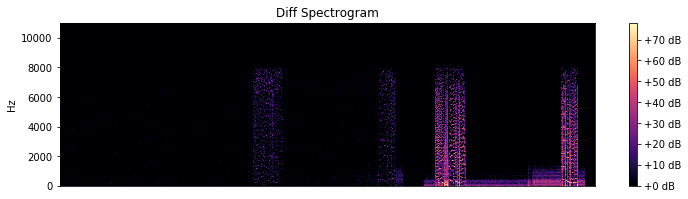

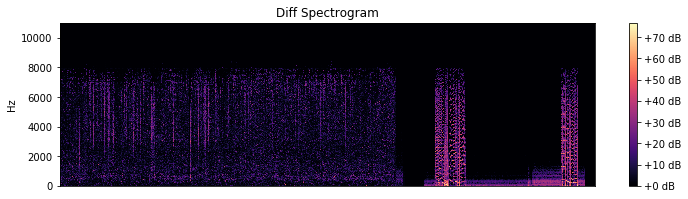

In [22]:
estimated_mix_ch, sr = sf.read('mixed_ch.wav')
estimated_mix, sr = sf.read('mixed.wav')
bandhub_mix, sr = sf.read('premix.wav')

estimated_mix_spec,bandhub_mix_spec = compute_offset_and_shift(estimated_mix, bandhub_mix, sr)
estimated_mix_ch_spec,bandhub_mix_spec = compute_offset_and_shift(estimated_mix_ch, bandhub_mix, sr)

root_mean_sq_error = plot_diff_spectrogram(estimated_mix_spec,bandhub_mix_spec)
print('RMSE for estimated mix using volume from settings: '+str(root_mean_sq_error))
root_mean_sq_error = plot_diff_spectrogram(estimated_mix_ch_spec,bandhub_mix_spec)
print('RMSE for estimated mix using volume from channels: '+str(root_mean_sq_error))

In [ ]:
# 